# Test on CIB extraction

In [2]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -1.796e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.668e+01 [aplpy.core]


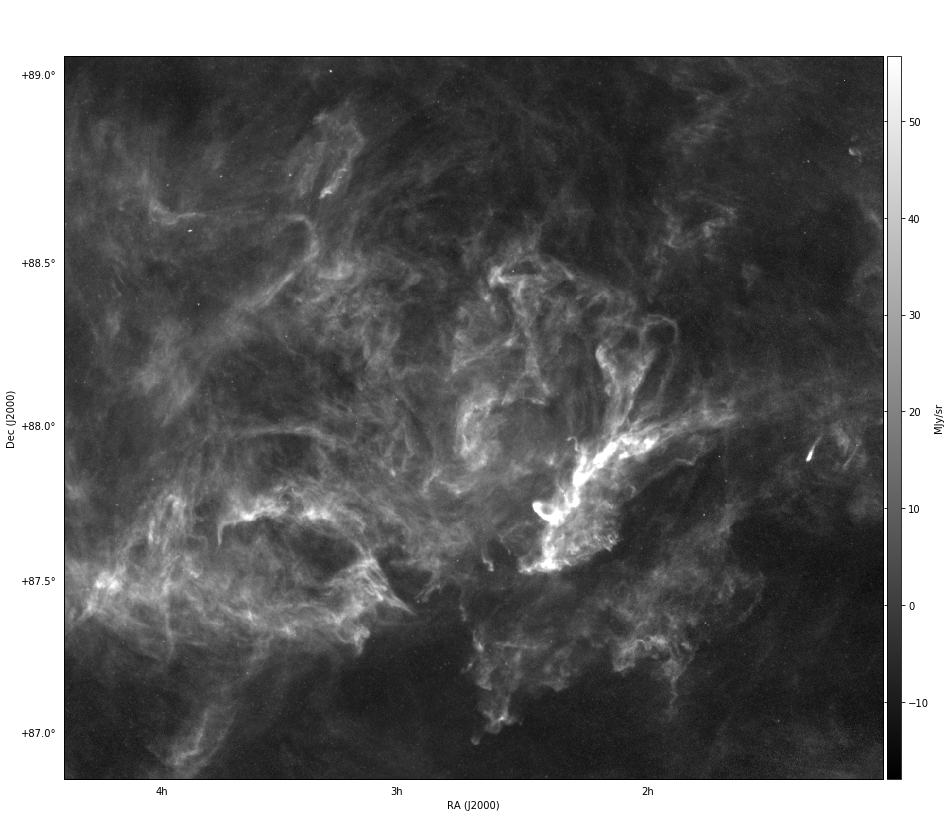

In [4]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/polaris-250_cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'MJy/sr')

In [6]:
from powspec import powspec
from wavan import apodize, padding
from gauss_beam import gauss_beam

In [37]:
#Read maps
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

HDUb = fits.open("/Users/robitaij/postdoc/Herschel/beams/empiral_spire_beam_250.fits")
beam = HDUb[0].data

## Fourier Power Spectrum

In [45]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - 20.1
imzm = im - np.mean(im)

#Apodization
tapper = apodize(nb,na,0.97)
imt = imzm *tapper
imr = padding(imt,1800,1800)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Put in Jy^2/sr
spec_k = spec_k*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12

#Beam power spectrum
beamr = padding(beam,1800,1800)
tab_k, spec_b = powspec(beamr, reso=reso)
#Normalisation
spec_b = spec_b/spec_b[0]

#Noise
Noise = mean(spec_k[(tab_k >=4.) & (tab_k<=5.)])

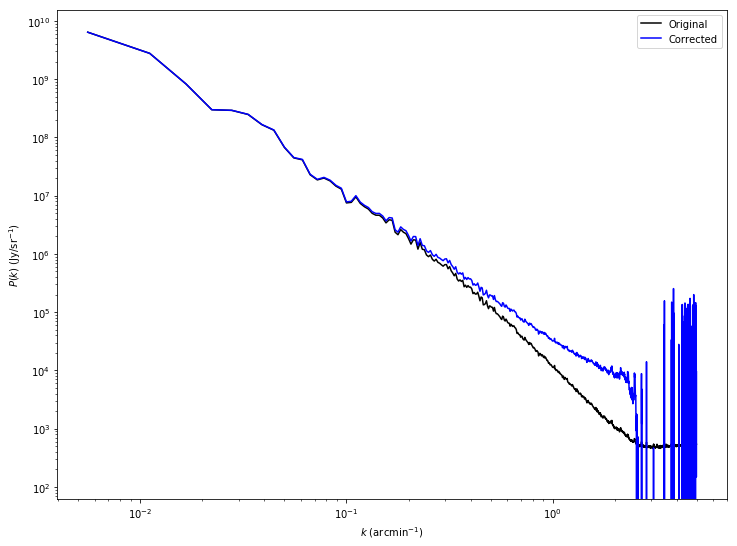

In [46]:
plt.figure(figsize=(12,9))
plt.plot(tab_k, spec_k, color='black',label='Original', linewidth=1.5)
plt.plot(tab_k, (spec_k-Noise)/spec_b, color='blue',label='Corrected', linewidth=1.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$ (Jy/sr$^{-1}$)")
plt.legend()

## Wavelet Power Spectrum

In [54]:
#Beam wavelet power spectrum
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False, arrdim = np.array([1800,1800]), cutpad=False)
#del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]
BS1an[0:4] = 1. 

#Set a list of q (threshold parameter)
q=[]
q=[2.5]*26

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, skewl=0.4, apodize= 0.97, arrdim = np.array([1800,1800]), cutpad=True)

#Put in Jy^2/sr
#S1a = S1a*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12

In [84]:
from scipy.optimize import curve_fit

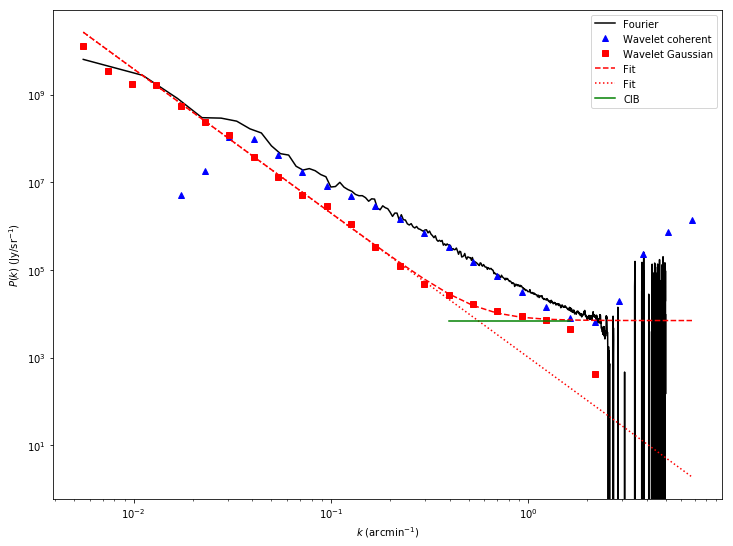

In [130]:
plt.figure(figsize=(12,9))
plt.plot(tab_k, (spec_k-Noise)/spec_b, color='black',label='Fourier', linewidth=1.5)
plt.plot(wav_k, (S1a[1,:])/BS1an,'^',color='blue',label='Wavelet coherent')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'s',color='red',label='Wavelet Gaussian')
#plt.plot(wav_k, (S1a[2,:]+S1a[1,:]-Noise)/BS1an,'D',color='black',label='Sum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$ (Jy/sr$^{-1}$)")

#Fit for the Gaussian part (curve_fit doesn't fit properly)
#def func(x,a,b,c):
#    return a * x**b + c

#A, Acov = curve_fit(func, wav_k[3:19], (S1a[2,3:19]-Noise)/BS1an[3:19],p0=[1022.,-3.3,1e4],bounds=([1.e2,-3.6,1.e3], [2.e3, -2.5, 1.e5]))

#Pfit = A[0]*wav_k**A[1]+A[2]

coef,cov = np.polyfit(np.log(wav_k[3:14]),np.log((S1a[2,3:14]-Noise)/BS1an[3:14]),deg=1,cov=True)
yfit = np.exp(coef[1])*wav_k**coef[0]
CIB = 7e3

plt.plot(wav_k, yfit+CIB,"--",color="red",label="Fit")
plt.plot(wav_k, yfit,":",color="red",label="Fit")
plt.plot([wav_k[15],wav_k[20]], [CIB,CIB],color="green",label="CIB")
plt.legend()

The segmented power spectra are modelled as follow:

$$P^F(k) = P_{\textrm{sky}}^G(k) + P_{\textrm{sky}}^C(k),$$

where $P_{\textrm{sky}}^G(k)$ is the Gaussian component, $P_{\textrm{sky}}^C(k))$ is the coherent (or non-Gaussian) component and $\phi(k)$ is the telescope transfer function. Also,

$$P_{\textrm{sky}}^G(k) = \phi(k) (A_{\textrm{ISM}}^G k^{\gamma_G} + P_{\textrm{CIB}}(k)) + N(k)$$

and

$$P_{\textrm{sky}}^C(k) = \phi(k) (A_{\textrm{ISM}}^C k^{\gamma_C} + P_{\textrm {src}})$$

Thus, after segmentation, the CIB and the noise are associated, at small spatial scales, with the Gaussian component of the map. The point sources, $P_{\textrm {src}}$, are associated with the non-Gaussian component of the map.

## Plot maps

INFO: Auto-setting vmin to -2.258e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.470e+01 [aplpy.core]
INFO: Auto-setting vmin to -2.852e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.595e+01 [aplpy.core]


Text(0.5,1,u'Non-Gaussiannities at the CIB scales')

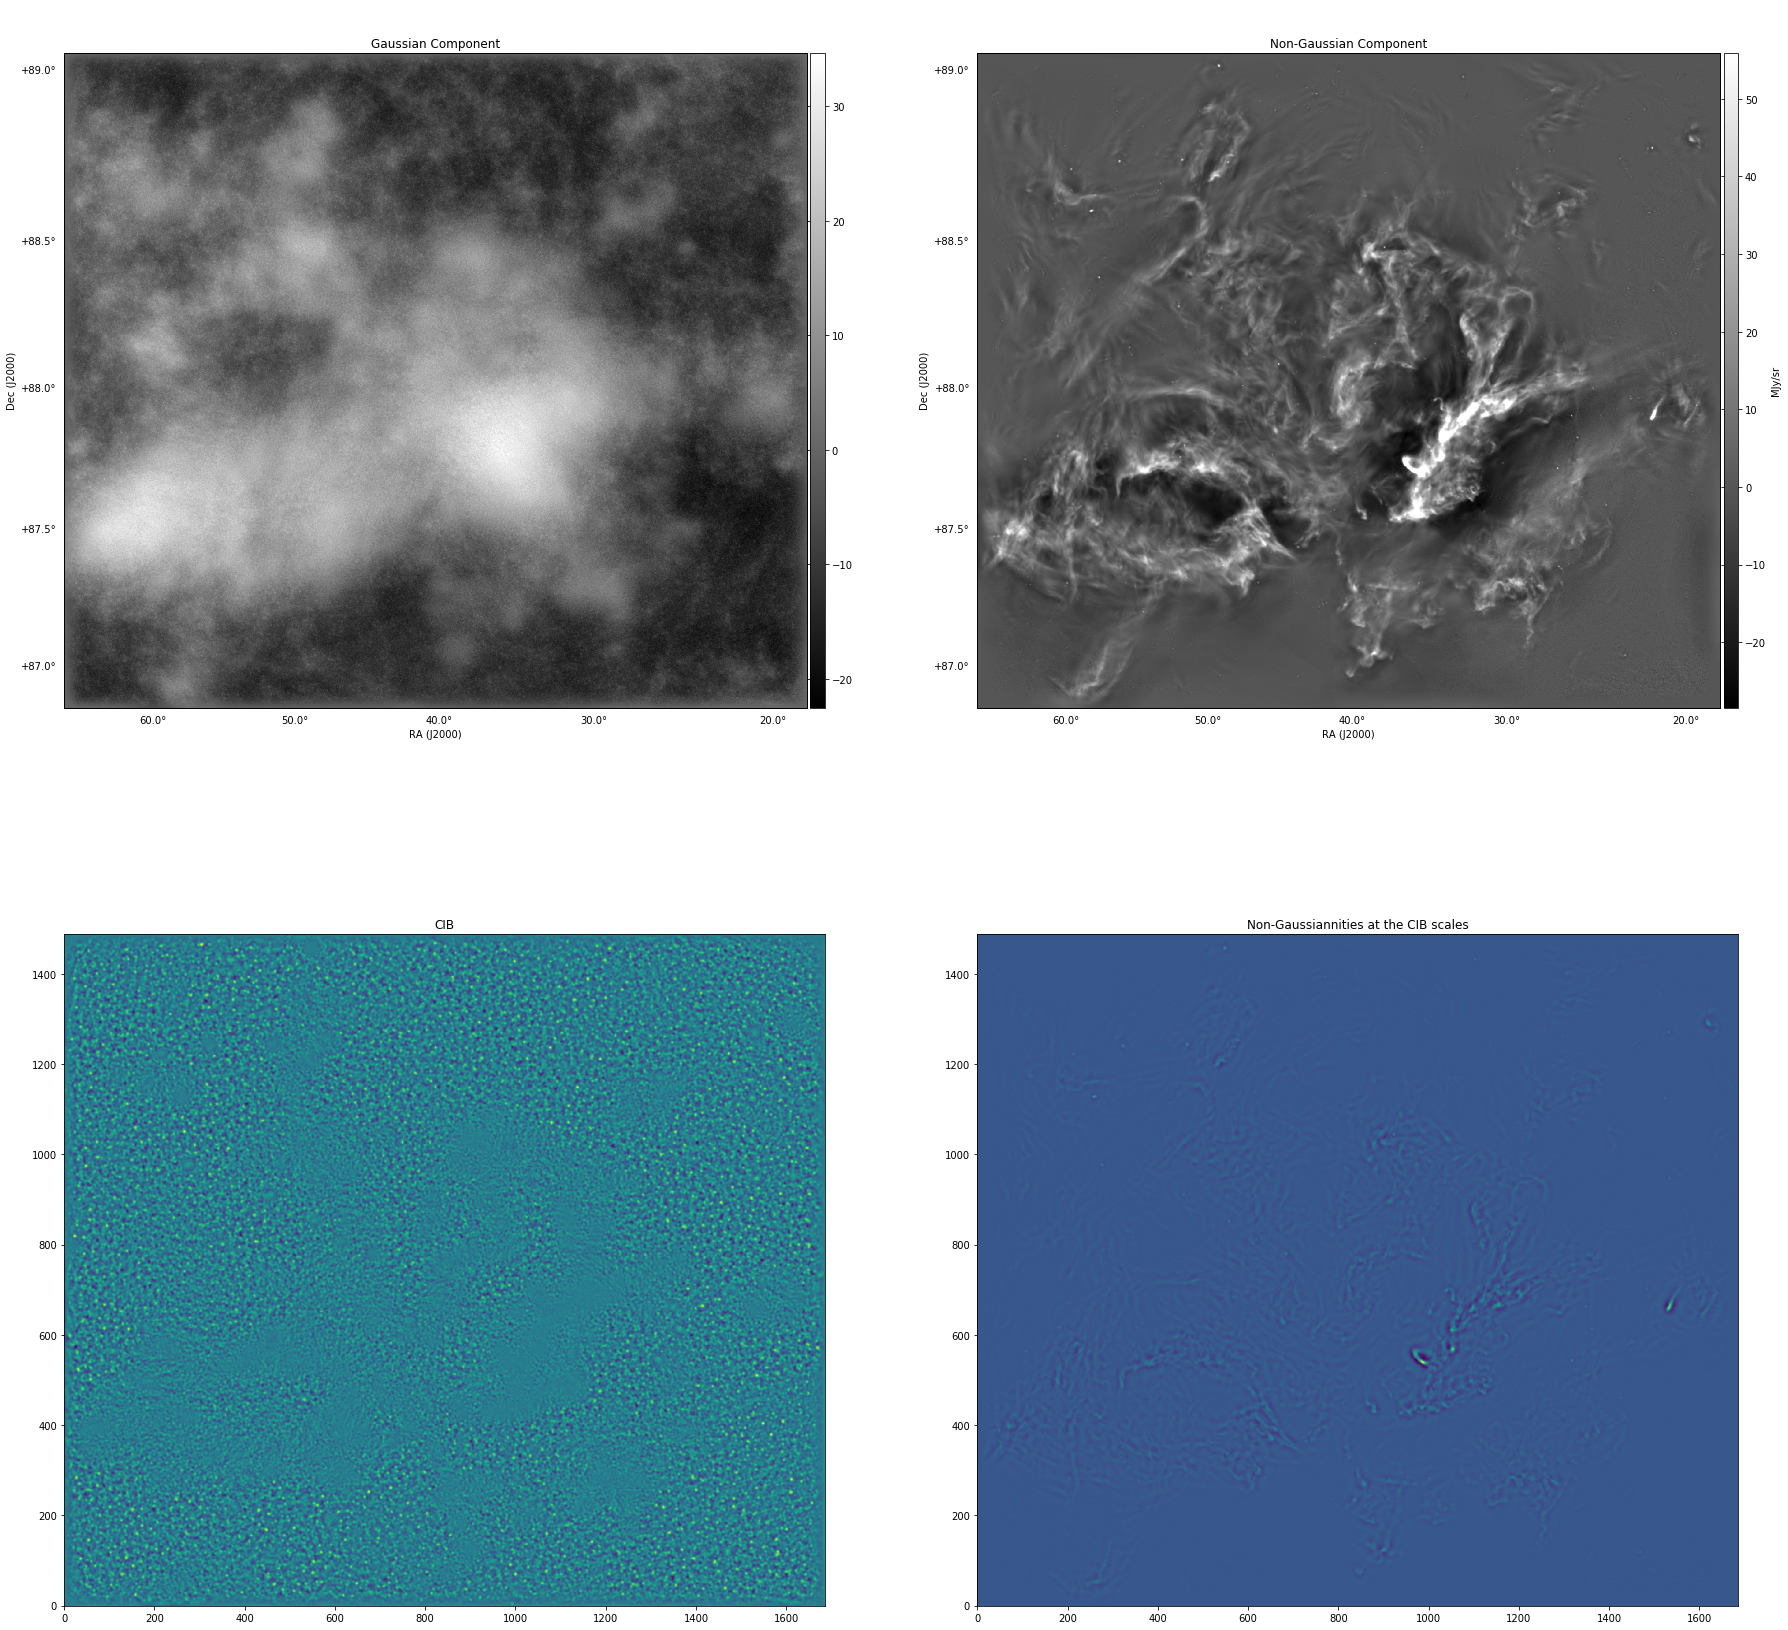

In [133]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_250_cohe.fits',\
            coherent.real,HDU[0].header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_250_gaussian.fits',\
            Gaussian.real,HDU[0].header,overwrite=True)

fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_250_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.set_title("Gaussian Component")

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_250_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'MJy/sr')
fig.set_title("Non-Gaussian Component")

plt.subplot(2,2,3)
imshow(np.sum(wt[2*M+15:2*M+20,:,:],axis=0).real,origin='below')
plt.title("CIB")

plt.subplot(2,2,4)
imshow(np.sum(wt[M+15:M+20,:,:],axis=0).real,origin='below')
plt.title("Non-Gaussiannities at the CIB scales")

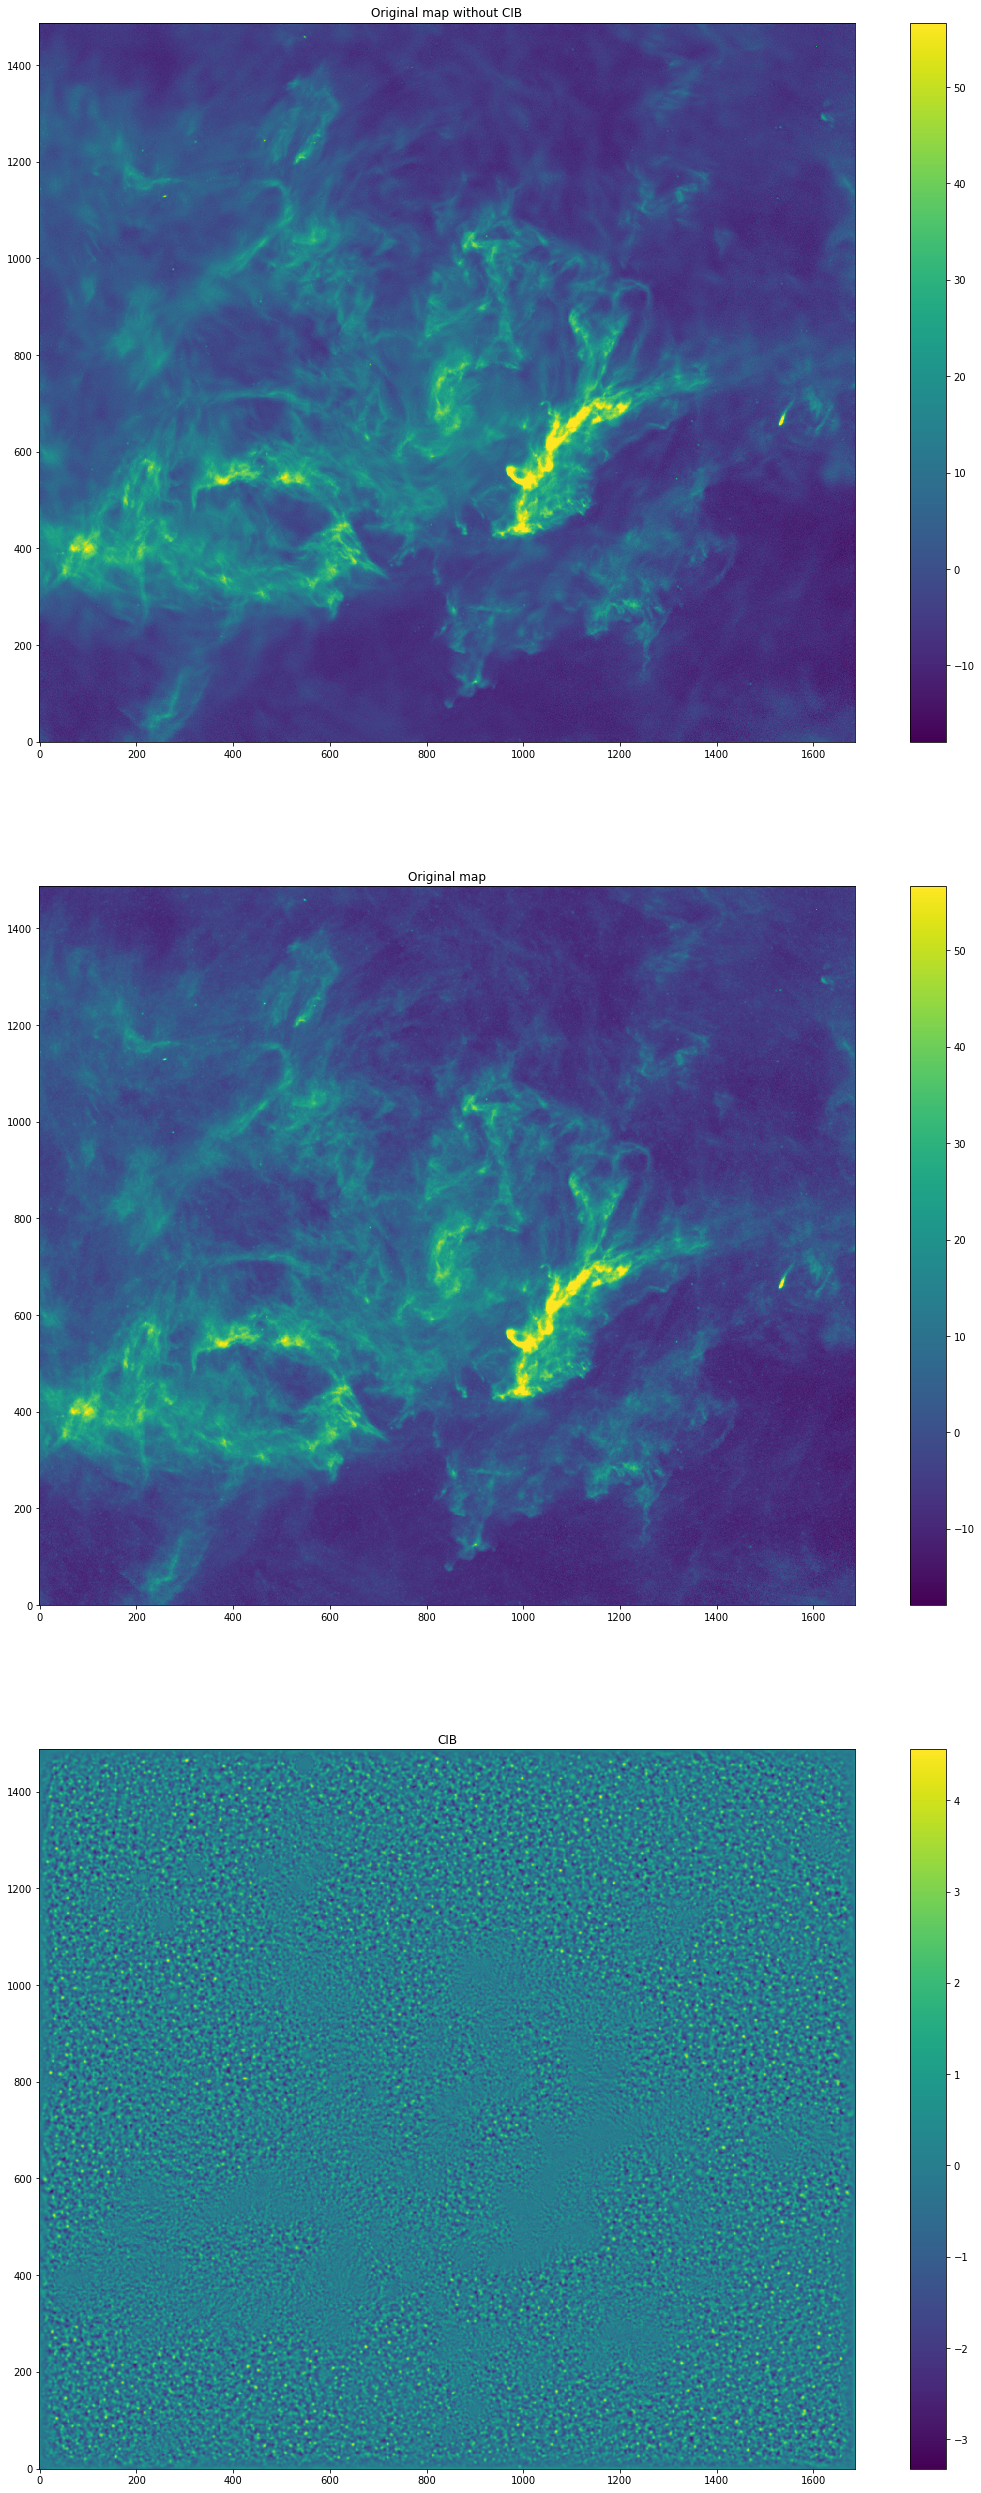

In [82]:
CIB = np.sum(wt[2*M+15:2*M+20,:,:],axis=0).real

plt.figure(figsize=(20,45))

plt.subplot(3,1,1)
plt.title("Original map without CIB")
imshow(im-CIB,origin='below',vmin=-1.796e+01, vmax=5.668e+01)
colorbar()

plt.subplot(3,1,2)
plt.title("Original map")
imshow(im,origin='below',vmin=-1.796e+01, vmax=5.668e+01)
colorbar()

plt.subplot(3,1,3)
plt.title("CIB")
imshow(CIB,origin='below')
colorbar()

fits.writeto("/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/polaris-250-cib_cut.fits",im-CIB,HDU[0].header,overwrite=True)